# Using Convolutional Neural Networks for food 101

Classfication of food items using the food101 training set and vgg16 model

#### preparing the ec-2 machine


In [ ]:
# ! sudo apt-get install git
# # if fails: 
# ! sudo apt-get install aptitude
# ! sudo aptitude install git
# #--------------------------
# ! sudo apt-get install unzip


#### Get the data:

Get the food101 data (~5GB): 
Log in to your kaggle account form Chrome, and using the chrome.txgt extention export your cookies to the kaggle_cookies.txt file. Copy the file to you r ec-2 instance and wget the data using the commanmd below: 

In [ ]:
# import os
# !wget -x --load-cookies kaggle_cookies.txt  -P data -nH --cut-dirs=5 https://www.kaggle.com/dansbecker/food-101/downloads/food-101.zip
# os.chdir('data')
# ! unzip -o "food-101.zip"
# ! unzip  "food-101.zip"
# os.chdir('../')

## Create sample colection for fast development

In [1]:
import os 
import shutil

n_sample_tr = 50 # number of training images per class
n_sample_val = 20 # number of validation images per class
n_sample_tst= 2 # number of testing images per class

classes = ['macaroni_and_cheese', 'pad_thai', 'pizza', 'hot_dog',
           'ice_cream', 'tiramisu', 'falafel', 'caprese_salad', 'chicken_curry', 'steak']
# classes = ['macaroni_and_cheese']


path_src= "/Users/avibraun/Projects/food101/data/food-101/images"
path_dest = "/Users/avibraun/Projects/food101/data/sample/"

dst_test = os.path.join(path_dest, 'test', 'non_class_images')

for class_ in classes:
    src = os.path.join(path_src, class_)
    dst_train = os.path.join(path_dest, 'train', class_)
    dst_valid = os.path.join(path_dest, 'valid', class_)

    src_files = os.listdir(src)[0:n_sample_tr + n_sample_val + n_sample_tst]
#     print (src_files)

    try:
        os.mkdir(dst_train)
        os.mkdir(dst_valid)
        
    except FileExistsError:
        shutil.rmtree(dst_train)
        shutil.rmtree(dst_valid)

        os.mkdir(dst_train)
        os.mkdir(dst_valid)
        
    [shutil.copy(os.path.join(src,src_file), dst_train) for src_file in src_files[:n_sample_tr]]
    [shutil.copy(os.path.join(src,src_file), dst_valid) for src_file in src_files[n_sample_tr:-n_sample_tst]]
    [shutil.copy(os.path.join(src,src_file), dst_test) for src_file in src_files[n_sample_tr+n_sample_val:]]

    

print('Finishesd creating training and validation sample folder')    

Finishesd creating training and validation sample folder


## Basic setup

There isn't too much to do to get started - just a few simple configuration steps.

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [2]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [3]:
path = "/home/ubuntu/"
path = "/Users/avibraun/Projects/food101/data/sample/"

A few basic libraries that we'll need for the initial exercises:

In [4]:
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [5]:
# ! pip install bcolz==1.1.2
# ! pip install theano==1.0.1
# ! pip install keras==1.1.2

from importlib import reload
import utils; reload(utils)
from utils import plots

Using Theano backend.


In [6]:
# Use a pretrained VGG model with our **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

We have created a python class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

## The punchline: state of the art custom model in 7 lines of code

Here's everything you need to do to get >97% accuracy on the Dogs vs Cats dataset - we won't analyze how it works behind the scenes yet, since at this stage we're just going to focus on the minimum necessary to actually do useful work.

In [7]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

In [8]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [9]:
vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=2)

Found 500 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Epoch 1/2
500/500 [==============================] - 175s - loss: 3.3902 - acc: 0.2280 - val_loss: 1.3320 - val_acc: 0.5450
Epoch 2/2
500/500 [==============================] - 167s - loss: 1.6257 - acc: 0.5300 - val_loss: 0.8850 - val_acc: 0.6950


In [ ]:
# val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
# imgs,labels = next(val_batches)

## Plotting test images and predictions

In [13]:
batch_size = 6
batches = vgg.get_batches(path+'test', batch_size=6)

Found 90 images belonging to 1 classes.


array([ 0.9305,  0.9999,  0.7089,  0.5332,  0.8428,  0.3914], dtype=float32)

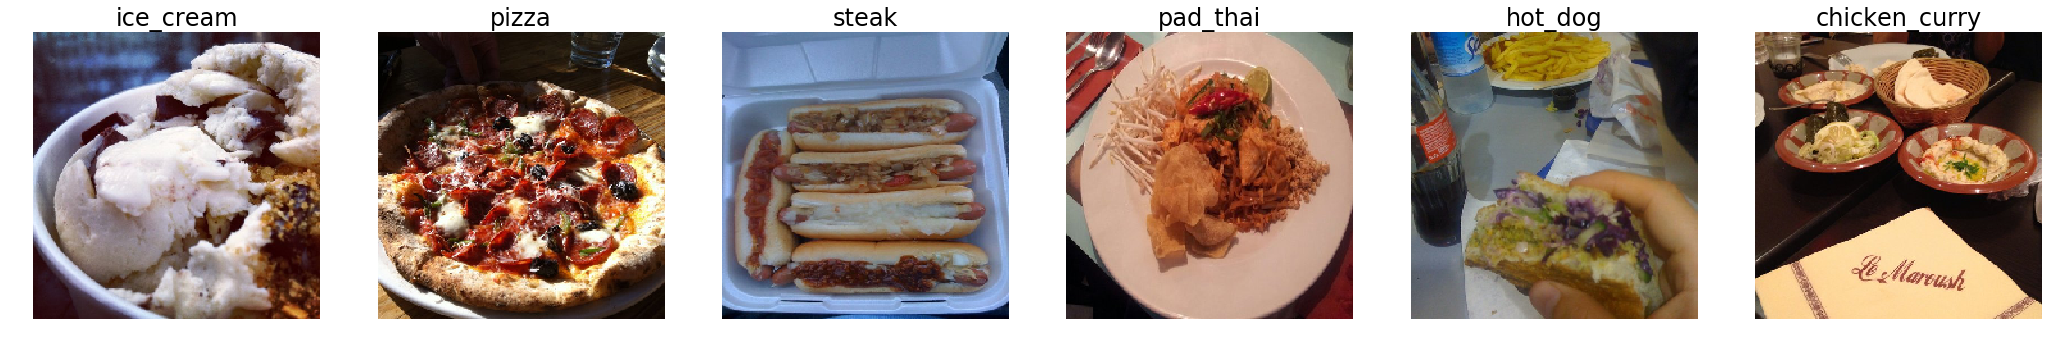

In [18]:
imgs,labels = next(batches)
plots(imgs, titles=vgg.predict(imgs, True)[2])
vgg.predict(imgs, True)[0]

The code above will work for any image recognition task, with any number of categories! All you have to do is to put your images into one folder per category, and run the code above.

Let's take a look at how this works, step by step...

# Create a VGG model from scratch in Keras

For the rest of this tutorial, we will not be using the Vgg16 class at all. Instead, we will recreate from scratch the functionality we just used. This is not necessary if all you want to do is use the existing model - but if you want to create your own models, you'll need to understand these details. It will also help you in the future when you debug any problems with your models, since you'll understand what's going on behind the scenes.

## Model setup

We need to import all the modules we'll be using from numpy, scipy, and keras:

In [19]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Let's import the mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.

In [20]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Here's a few examples of the categories we just imported:

In [21]:
classes[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [22]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

...and here's the fully-connected definition.

In [23]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [24]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

Now we're ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

In [25]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

Now that we've defined the architecture, we can create the model like any python object:

In [26]:
model = VGG_16()

As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem. 

Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.

In [27]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Getting imagenet predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [28]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [29]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

From here we can use exactly the same steps as before to look at predictions from the model.

Found 500 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Shape: (4, 1000)
Predictions prob/class: 
  0.2113/plate
  0.8440/chocolate_sauce
  0.0881/spiny_lobster
  0.1004/chocolate_sauce


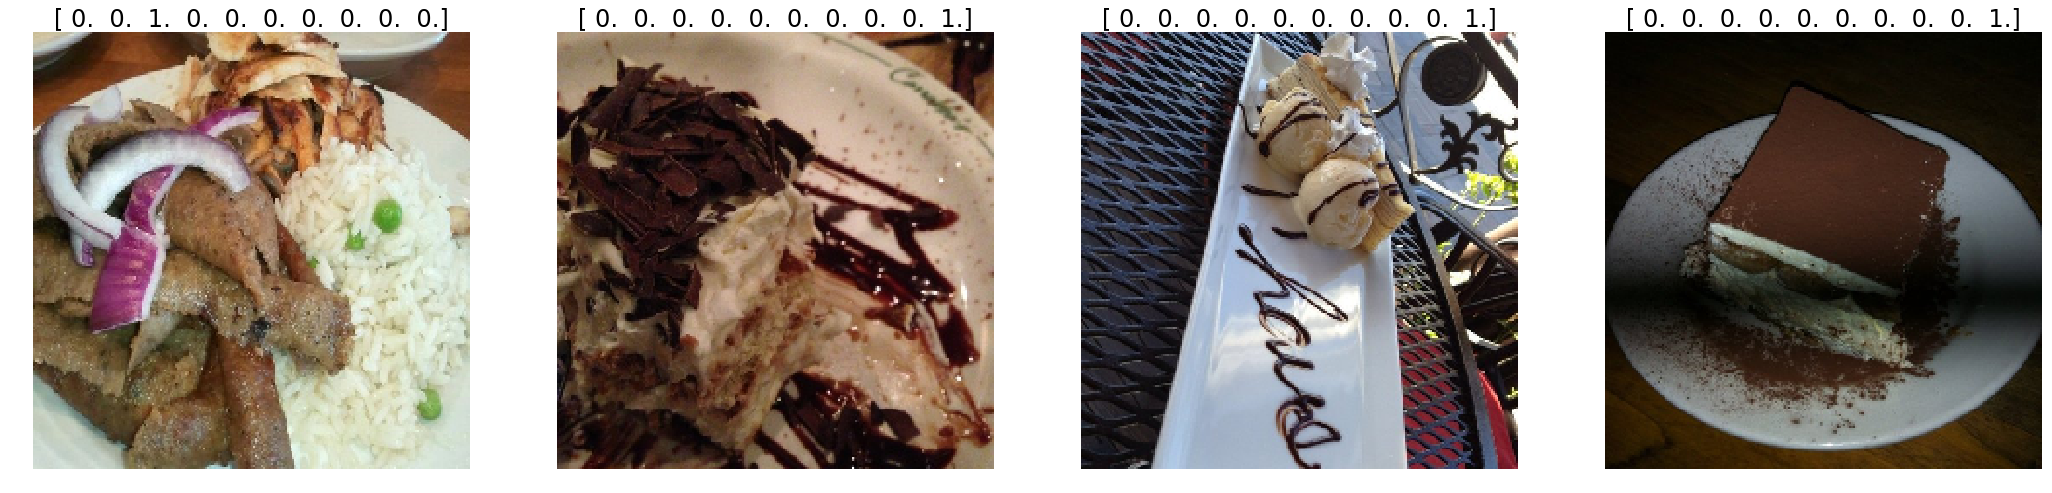

In [37]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'`

plots(imgs, titles=labels)
pred_batch(imgs)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with *np.argmax()*) we can find the predicted label.

In [34]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
#     print('First 5 classes: {}'.format(classes[:5]))
#     print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [32]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities: [  8.5532e-09   2.2016e-08   6.5352e-11   2.2774e-10   9.7645e-10]

Predictions prob/class: 
  0.9677/pizza
  0.3153/ice_cream
  0.1855/wok
  0.1246/ice_cream
